In [1]:
import os
import numpy as np
import imageio

In [3]:
!pip install imageio  --index https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 6.2 MB/s eta 0:00:0000:01


In [2]:
raw_path = '../md17'

In [3]:
molecule_files = dict(
    Aspirin="aspirin_dft.npz",
    Benzene="benzene_dft.npz",
    Ethanol="ethanol_dft.npz",
    Malonaldehyde="malonaldehyde_dft.npz",
    Naphthalene="naphthalene_dft.npz",
    Salicylic="salicylic_dft.npz",
    Toluene="toluene_dft.npz",
    Uracil="uracil_dft.npz",
)

In [4]:
def read_mol(mol_name):
    npz_file = np.load(os.path.join(raw_path, molecule_files[mol_name]))
    z = npz_file['z']
    x_all = npz_file['R']
    x = x_all[:, z > 1]
    return z, x_all, x

In [14]:
tar_mol = 'Malonaldehyde'
z, x_all, x = read_mol(tar_mol)
print(z)

[6 6 6 8 8 1 1 1 1]


In [15]:
dic = {1:'H', 6: 'C', 8:'O', 7:'N'}

In [16]:
from xyz2mol import *

In [3]:
now_index = 128047
past_index = [now_index - i*10  for i in range(10, 0, -1)]
past_index

[127947,
 127957,
 127967,
 127977,
 127987,
 127997,
 128007,
 128017,
 128027,
 128037]

In [17]:
def get_mol(ind):
    print(ind)
    x_mol = x_all[ind]
    mols = xyz2mol(z.tolist(), x_mol.tolist(),
                charge=0,
                use_graph=True,
                allow_charged_fragments=True,
                embed_chiral=True,
                use_huckel=False)
    return mols[0]

128047


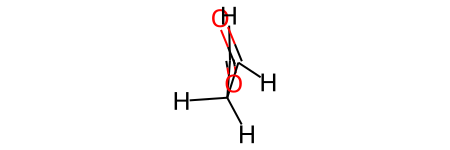

In [18]:
example_mol = get_mol(now_index)
example_mol

In [35]:
from rdkit.Chem import PyMol
v = PyMol.MolViewer()
from PIL import Image, ImageDraw, ImageFont

def cuthead(img, size=10):
    im = np.array(img)
    cutspace = im[:size,:,:]
    cvs = np.ones_like(cutspace) * 255
    im[:size,:,:] = cvs   
    img2 = Image.fromarray(im).convert('RGB')
    return img2

def add_caption(img, molecule, method, step, mae = None, fontsize=20):
    ime = ImageDraw.Draw(img)
    # ft = ImageFont.truetype("times.ttf",size=fontsize)
    ft = ImageFont.load_default()
    ime.text((10,10),f"{molecule}, {method}",(0,0,0),font=ft)
    if mae is not None:
        ime.text((10,15+fontsize),f"Step={step}, MAE={mae:.4f}",(0,0,0),font=ft)
    else:
        ime.text((10,15+fontsize),f"Step={step}",(0,0,0),font=ft)


def show(ind):
    example_mol = get_mol(ind)
    # Visualize the example
    # v = PyMol.MolViewer()
    v.ShowMol(example_mol)
    v.server.do("color yellow, elem c")
    v.server.do("color orange, elem h")
    v.server.do("color blue, elem n")
    v.server.do("color red, elem o")
    img = v.GetPNG(h=300)
    # You may adjust the view in PyMol for better visualization
    img = cuthead(img)
    # add_caption(img, tar_mol, 'Example', 0, mae = 0.0, fontsize = 15)
    return img

In [36]:
img = show(past_index[10])

128047


In [49]:
img.save(f'vis/{tar_mol}_gt.png')

In [197]:
def set_rdmol_positions(rdkit_mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    mol = copy.deepcopy(rdkit_mol)
    set_rdmol_positions_(mol, pos)
    return mol


def set_rdmol_positions_(mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol

In [59]:
loc_pred = np.array([[-1.1885,  0.3116, -0.6747],
        [-0.0237,  0.8144, -1.1451],        [ 1.2061,  0.4384, -0.5264],        [ 1.2043, -0.2609,  0.6985],        [-0.0281, -0.8106,  1.1351],
        [-1.2149, -0.4542,  0.5240]])

In [24]:
print(loc_pred.shape)

(8, 3)


In [60]:
# x = np.array(x_all[now_index])

x = np.array([[-1.1841,  0.3039, -0.6663],        [-0.0100,  0.7965, -1.1339],        [ 1.2122,  0.4357, -0.5211],        [ 1.2202, -0.2841,  0.7040],        [-0.0149, -0.8246,  1.1363],        [-1.2044, -0.4706,  0.5270],        [-2.1085,  0.6681, -1.1761],        [ 0.0214,  1.3515, -2.0826],
        [ 2.1358,  0.8502, -0.8732],        [ 2.1501, -0.5980,  1.1671],        [-0.0215, -1.5188,  1.9750],        [-2.1958, -0.7096,  0.9437]])
x[np.array(z) > 1] = loc_pred

In [61]:
try:
    mols = xyz2mol(z, x,
                    charge=0,
                    use_graph=True,
                    allow_charged_fragments=True,
                    embed_chiral=True,
                    use_huckel=False)
except Exception as e:
    print(e)

# print(mols)
mol = mols[0]
v.ShowMol(mol)
v.server.do("color yellow, elem c")
v.server.do("color orange, elem h")
v.server.do("color blue, elem n")
v.server.do("color red, elem o")
img = v.GetPNG(h=300)
# You may adjust the view in PyMol for better visualization
img = cuthead(img)

In [62]:
img.save(f'vis/{tar_mol}_egnn.png')

In [32]:
from rdkit.Chem import PyMol

Run 'pymol -R' in Bash before the following block to start PyMol first. 

In [33]:
v = PyMol.MolViewer()

ConnectionRefusedError: [Errno 111] Connection refused

## Settings in PyMol

Display -> Background -> White

Display -> Color Space -> CMYK

Setting -> Lines & Sticks -> Ball and Stick

Setting -> Lines & Sticks -> Ball and Stick Ratio -> 1.5

(PyMol>) set stick_radius=0.15

In [15]:
from PIL import Image, ImageDraw, ImageFont

In [16]:
def cuthead(img, size=10):
    im = np.array(img)
    cutspace = im[:size,:,:]
    cvs = np.ones_like(cutspace) * 255
    im[:size,:,:] = cvs   
    img2 = Image.fromarray(im).convert('RGB')
    return img2

In [17]:
def add_caption(img, molecule, method, step, mae = None, fontsize=20):
    ime = ImageDraw.Draw(img)
    ft = ImageFont.truetype("times.ttf",size=fontsize)
    ime.text((10,10),f"{molecule}, {method}",(0,0,0),font=ft)
    if mae is not None:
        ime.text((10,15+fontsize),f"Step={step}, MAE={mae:.4f}",(0,0,0),font=ft)
    else:
        ime.text((10,15+fontsize),f"Step={step}",(0,0,0),font=ft)

In [18]:
# Visualize the example
v.ShowMol(example_mol)
v.server.do("color yellow, elem c")
v.server.do("color orange, elem h")
v.server.do("color blue, elem n")
v.server.do("color red, elem o")
img = v.GetPNG(h=300)
# You may adjust the view in PyMol for better visualization
img = cuthead(img)
add_caption(img, tar_mol, 'Example', 0, mae = 0.0, fontsize = 15)

NameError: name 'v' is not defined

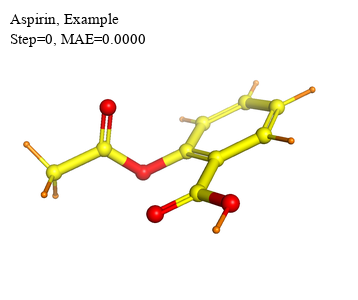

In [22]:
img

In [23]:
os.makedirs('vis',exist_ok=True)

In [24]:
from tqdm import tqdm

In [ ]:
# molecule_files = dict(
#     Aspirin="aspirin_dft.npz",
#     Benzene="benzene_dft.npz",
#     Ethanol="ethanol_dft.npz",
#     Malonaldehyde="malonaldehyde_dft.npz",
#     Naphthalene="naphthalene_dft.npz",
#     Salicylic="salicylic_dft.npz",
#     Toluene="toluene_dft.npz",
#     Uracil="uracil_dft.npz",
# )

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

In [5]:
tar_mol = 'Malonaldehyde'
z, x_all, x = read_mol(tar_mol)
x.shape

(993237, 5, 3)

In [7]:
# temp_x = x[127947:max(327947, len(x))]
temp_x = x[120000:121024]
temp_x.shape

(1024, 5, 3)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

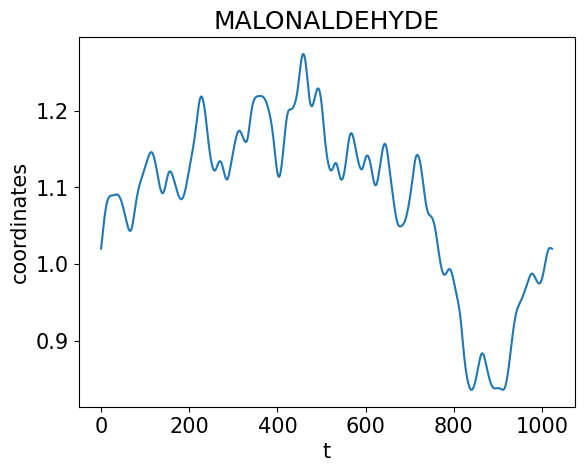

In [10]:
import torch
data = temp_x[:, 0, 2]

# data = data / np.max(np.abs(data))
plt.xlabel('t')
plt.ylabel('coordinates')
plt.title(tar_mol.upper())
plt.plot(data)
# plt.savefig(f'vis/{tar_mol}_T.pdf')
plt.show()

tensor([1.0203, 1.0252, 1.0305,  ..., 1.0208, 1.0205, 1.0203],
       dtype=torch.float64)
tensor([1.0203, 1.0252, 1.0305,  ..., 1.0208, 1.0205, 1.0203],
       dtype=torch.float64)


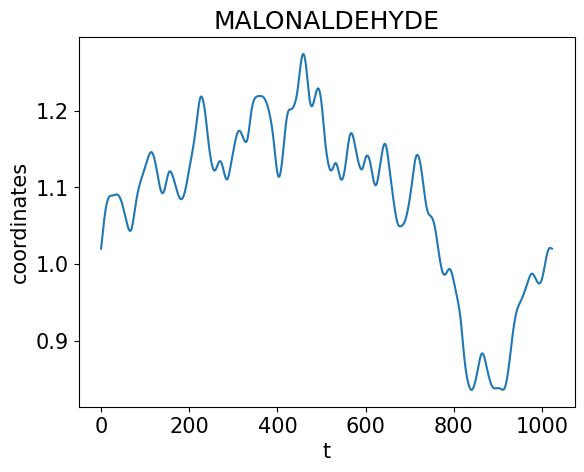

tensor(1.0850e-31, dtype=torch.float64)

In [22]:
time_series =  torch.from_numpy(data)
n_fft = 256
hop_length = 64
win_length = n_fft
window = torch.hann_window(win_length)
stft_result = torch.stft(time_series, 
                         n_fft=n_fft, 
                         hop_length=hop_length, 
                         win_length=win_length, 
                         window=window, 
                         return_complex=True)

# (可选) 对 STFT 结果进行某种形式的处理
processed_stft = stft_result  # 在这里不做处理

# 使用 ISTFT 恢复信号
reconstructed_signal = torch.istft(processed_stft, 
                                   n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   win_length=win_length, 
                                   window=window)
# data = data / np.max(np.abs(data))
plt.xlabel('t')
plt.ylabel('coordinates')
plt.title(tar_mol.upper())
plt.plot(reconstructed_signal)
print(reconstructed_signal)
print(time_series)
# plt.savefig(f'vis/{tar_mol}_T.pdf')
plt.show()
error = torch.mean((time_series - reconstructed_signal_real) ** 2)
error

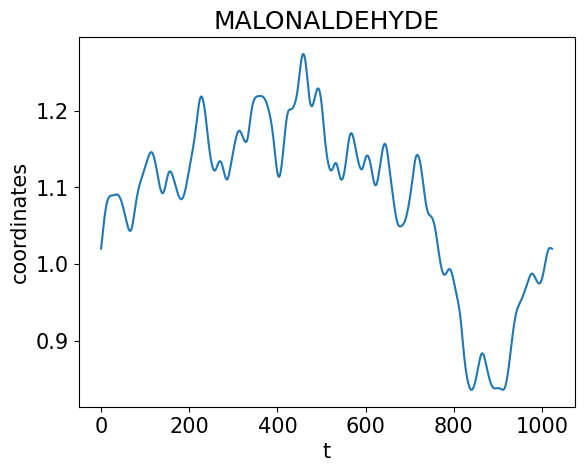

tensor(1.0850e-31, dtype=torch.float64)

In [19]:
time_series =  torch.from_numpy(data)
fft_result = torch.fft.fft(time_series)
reconstructed_signal = torch.fft.ifft(fft_result)
reconstructed_signal_real = reconstructed_signal.real

# data = data / np.max(np.abs(data))
plt.xlabel('t')
plt.ylabel('coordinates')
plt.title(tar_mol.upper())
plt.plot(reconstructed_signal_real)
plt.show()
error = torch.mean((time_series - reconstructed_signal_real) ** 2)
error

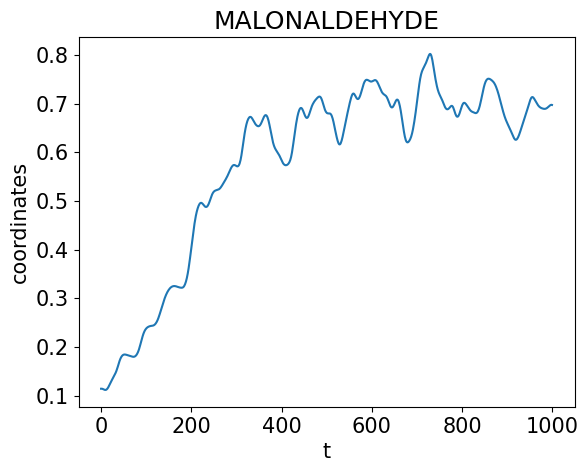

In [44]:
data = temp_x[:, 0, 0]
# data = data / np.max(np.abs(data))
plt.xlabel('t')
plt.ylabel('coordinates')
plt.title(tar_mol.upper())
plt.plot(data)
# plt.savefig(f'vis/{tar_mol}_T.pdf')
plt.show()

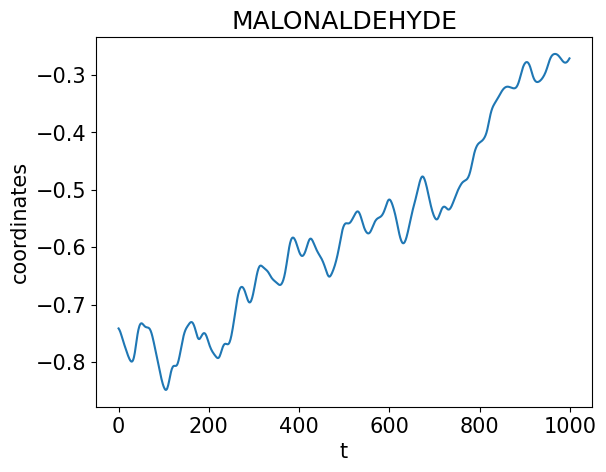

In [45]:
data = temp_x[:, 0, 1]
# data = data / np.max(np.abs(data))
plt.xlabel('t')
plt.ylabel('coordinates')
plt.title(tar_mol.upper())
plt.plot(data)
# plt.savefig(f'vis/{tar_mol}_T.pdf')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
# molecule_files = dict(
#     Aspirin="aspirin_dft.npz",
#     Benzene="benzene_dft.npz",
#     Ethanol="ethanol_dft.npz",
#     Malonaldehyde="malonaldehyde_dft.npz",
#     Naphthalene="naphthalene_dft.npz",
#     Salicylic="salicylic_dft.npz",
#     Toluene="toluene_dft.npz",
#     Uracil="uracil_dft.npz",
# )

: 

In [5]:
tar_mol = 'Aspirin'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[1000: 1500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(211762, 13, 3)


NameError: name 'adfuller' is not defined

In [6]:
tar_mol = 'Benzene'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[1000: 1500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(627983, 6, 3)


NameError: name 'adfuller' is not defined

In [7]:
tar_mol = 'Ethanol'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[1000: 1500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(555092, 3, 3)


NameError: name 'adfuller' is not defined

In [8]:
tar_mol = 'Malonaldehyde'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[1000: 1500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(993237, 5, 3)


NameError: name 'adfuller' is not defined

In [9]:
tar_mol = 'Naphthalene'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[111000: 111500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(326250, 10, 3)


NameError: name 'adfuller' is not defined

In [10]:
tar_mol = 'Salicylic'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[11000: 11500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(320231, 10, 3)


NameError: name 'adfuller' is not defined

In [37]:
tar_mol = 'Toluene'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[12000: 12500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.960055
p-value: 0.038797
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [38]:
tar_mol = 'Uracil'
z, x_all, x = read_mol(tar_mol)
print(x.shape)
x = x[11000: 11500]
x.shape
result = adfuller(x[:, 0, 2])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.094228
p-value: 0.246842
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
